Using device: cuda
[Epoch 01] Loss: 0.2637 | Margin: 0.2637 | Recon: 0.1566 | Train Acc: 0.7708
[Epoch 02] Loss: 0.1162 | Margin: 0.1162 | Recon: 0.0674 | Train Acc: 0.9154

Test accuracy with routing=3: 0.9220


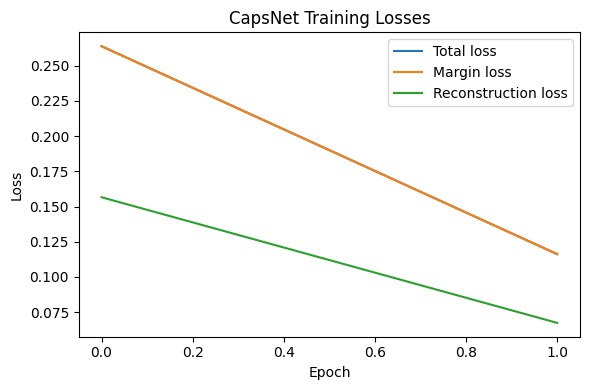

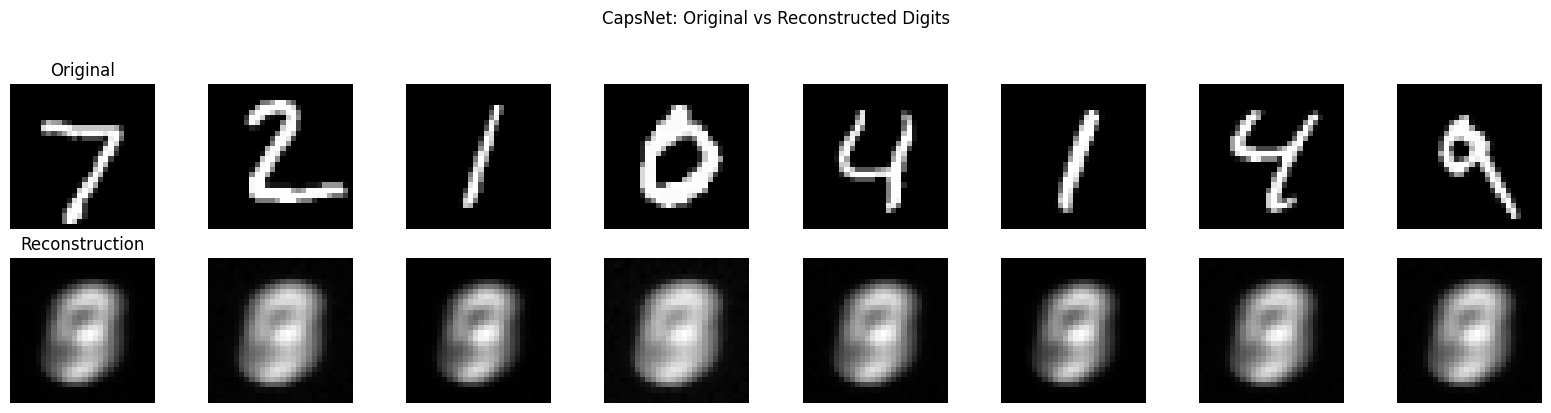


Evaluating robustness to rotations...
Rotation -30° -> accuracy: 0.6245
Rotation -15° -> accuracy: 0.8405
Rotation   0° -> accuracy: 0.9220
Rotation  15° -> accuracy: 0.7990
Rotation  30° -> accuracy: 0.5030


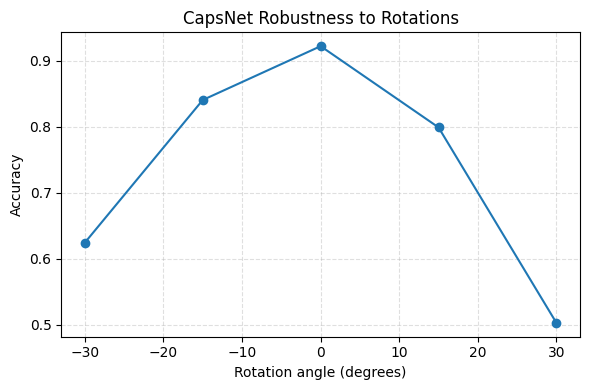


Evaluating effect of routing iterations on accuracy (no extra training)...
Routing iters = 1 -> test accuracy: 0.9225
Routing iters = 2 -> test accuracy: 0.9220
Routing iters = 3 -> test accuracy: 0.9220
Routing iters = 4 -> test accuracy: 0.9195


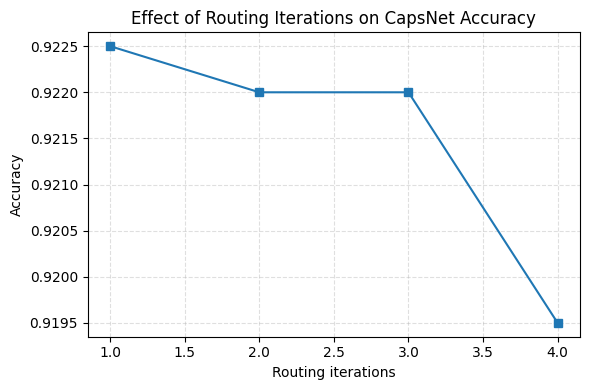


Saved figures in 'figures_capsnet/' folder:
 - capsnet_training_losses.png
 - capsnet_reconstructions.png
 - capsnet_rotation_robustness.png
 - capsnet_routing_vs_accuracy.png


In [2]:
# ============================================================
# Capsule Network (CapsNet) on MNIST – Lightweight, Single-Cell Demo
# - Trains a small CapsNet on a subset of MNIST
# - Evaluates reconstruction quality
# - Evaluates robustness to rotations
# - Evaluates effect of routing iterations on accuracy
# - Produces several plots and saves them to disk
# ============================================================

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

# -----------------------------
# 1. Reproducibility & Device
# -----------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 2. Dataset: MNIST (subset for speed)
# -----------------------------
transform = transforms.ToTensor()

train_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_full  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Use a subset so training is fast on CPU
NUM_TRAIN = 8000   # you can increase if you have more compute
NUM_TEST  = 2000

train_ds = Subset(train_full, list(range(NUM_TRAIN)))
test_ds  = Subset(test_full, list(range(NUM_TEST)))

batch_size = 128

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

# Directory to save figures
os.makedirs("figures_capsnet", exist_ok=True)

# -----------------------------
# 3. Capsule Network Components
# -----------------------------
def squash(s, dim=-1, eps=1e-7):
    """
    Non-linear squash function from Sabour et al. (2017).
    Scales vectors to length in (0, 1).
    """
    norm = torch.norm(s, dim=dim, keepdim=True)
    scale = (norm ** 2) / (1.0 + norm ** 2)
    return scale * s / (norm + eps)

class PrimaryCapsules(nn.Module):
    """
    Primary capsule layer implemented as a convolution.
    Outputs many small capsules spread spatially over the feature map.
    """
    def __init__(self, in_channels, num_capsules, dim_capsule, kernel_size, stride):
        super().__init__()
        self.num_capsules = num_capsules
        self.dim_capsule = dim_capsule
        self.conv = nn.Conv2d(in_channels, num_capsules * dim_capsule,
                              kernel_size=kernel_size, stride=stride)

    def forward(self, x):
        out = self.conv(x)  # [B, num_capsules*dim_capsule, H, W]
        B, C, H, W = out.size()
        # reshape to [B, num_capsules, dim_capsule, H, W]
        out = out.view(B, self.num_capsules, self.dim_capsule, H, W)
        # move spatial dims ahead: [B, H, W, num_capsules, dim_capsule]
        out = out.permute(0, 3, 4, 1, 2).contiguous()
        # flatten H, W, num_capsules -> num_primary_caps
        out = out.view(B, -1, self.dim_capsule)  # [B, num_primary_caps, dim_capsule]
        out = squash(out, dim=-1)
        return out

class DigitCapsules(nn.Module):
    """
    Fully connected capsule layer with dynamic routing.
    Maps many primary capsules to 10 digit capsules.
    """
    def __init__(self, num_caps_in, dim_caps_in, num_caps_out, dim_caps_out, routing_iters=3):
        super().__init__()
        self.num_caps_in = num_caps_in
        self.dim_caps_in = dim_caps_in
        self.num_caps_out = num_caps_out
        self.dim_caps_out = dim_caps_out
        self.routing_iters = routing_iters

        # Transformation matrices W_ij
        self.W = nn.Parameter(
            0.01 * torch.randn(1, num_caps_in, num_caps_out, dim_caps_out, dim_caps_in)
        )

    def forward(self, x):
        """
        x: [B, num_caps_in, dim_caps_in]
        returns: [B, num_caps_out, dim_caps_out]
        """
        B, N, D = x.size()
        assert N == self.num_caps_in and D == self.dim_caps_in

        # Expand x and W to shape [B, N, num_caps_out, dim_caps_out, 1]
        x = x.unsqueeze(2).unsqueeze(-1)              # [B, N, 1, D, 1]
        W = self.W.expand(B, -1, -1, -1, -1)         # [B, N, num_caps_out, dim_caps_out, dim_caps_in]
        u_hat = torch.matmul(W, x)                   # [B, N, num_caps_out, dim_caps_out, 1]

        # Routing logits b_ij
        b = torch.zeros(B, self.num_caps_in, self.num_caps_out, 1, device=x.device)

        for _ in range(self.routing_iters):
            c = torch.softmax(b, dim=2)              # [B, N, num_caps_out, 1]
            # Weighted sum over input capsules
            s = (c.unsqueeze(-2) * u_hat).sum(dim=1) # [B, num_caps_out, dim_caps_out, 1]
            v = squash(s, dim=2)                     # [B, num_caps_out, dim_caps_out, 1]
            # Agreement
            b = b + (u_hat * v.unsqueeze(1)).sum(dim=-2)  # [B, N, num_caps_out, 1]

        v = v.squeeze(-1)                            # [B, num_caps_out, dim_caps_out]
        return v

class CapsNet(nn.Module):
    """
    Simple CapsNet for MNIST with:
    - conv1
    - PrimaryCapsules
    - DigitCapsules
    - Decoder for reconstruction
    """
    def __init__(self, routing_iters=3):
        super().__init__()
        self.routing_iters = routing_iters

        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1)
        self.primary_caps = PrimaryCapsules(
            in_channels=64,
            num_capsules=8,
            dim_capsule=8,
            kernel_size=5,
            stride=2,
        )

        # Determine number of primary capsules dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            x = F.relu(self.conv1(dummy))
            primary = self.primary_caps(x)
            num_primary_caps = primary.size(1)

        self.digit_caps = DigitCapsules(
            num_caps_in=num_primary_caps,
            dim_caps_in=8,
            num_caps_out=10,
            dim_caps_out=16,
            routing_iters=routing_iters,
        )

        # Decoder network for reconstruction
        self.decoder = nn.Sequential(
            nn.Linear(10 * 16, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x, y=None):
        """
        x: [B, 1, 28, 28]
        y: labels [B] (optional, used for reconstruction mask)
        Returns:
        - logits: [B, 10] (length of digit capsules)
        - recon: [B, 1, 28, 28]
        """
        B = x.size(0)
        x = F.relu(self.conv1(x))
        primary = self.primary_caps(x)
        # Update routing_iters in digit_caps (so we can change it later)
        self.digit_caps.routing_iters = self.routing_iters
        digit_caps = self.digit_caps(primary)               # [B, 10, 16]

        logits = digit_caps.norm(dim=-1)                    # [B, 10]

        # If no labels provided, use predicted class for reconstruction
        if y is None:
            _, max_idx = logits.max(dim=1)
            y_onehot = F.one_hot(max_idx, num_classes=10).float()
        else:
            y_onehot = F.one_hot(y, num_classes=10).float()

        recon_input = (digit_caps * y_onehot.unsqueeze(-1)).view(B, -1)
        recon = self.decoder(recon_input).view(B, 1, 28, 28)

        return logits, recon

# -----------------------------
# 4. Loss and Training / Eval
# -----------------------------
def capsnet_loss(logits, target, recon, images, recon_coef=0.0005):
    """
    Margin loss + reconstruction loss as in Sabour et al. (2017).
    """
    B = images.size(0)
    target_onehot = F.one_hot(target, num_classes=10).float()

    v_c = logits
    m_plus = 0.9
    m_minus = 0.1
    lambda_ = 0.5

    L = target_onehot * F.relu(m_plus - v_c) ** 2 + \
        lambda_ * (1 - target_onehot) * F.relu(v_c - m_minus) ** 2
    margin_loss = L.sum(dim=1).mean()

    recon_loss = F.mse_loss(recon, images)

    loss = margin_loss + recon_coef * recon_loss
    return loss, margin_loss.detach(), recon_loss.detach()

def train_capsnet(model, optimizer, train_loader, epochs=2):
    model.to(device)
    history = {"loss": [], "margin": [], "recon": [], "acc": []}

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        running_margin = 0.0
        running_recon = 0.0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            logits, recon = model(data, target)
            loss, margin_loss, recon_loss = capsnet_loss(logits, target, recon, data)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * data.size(0)
            running_margin += margin_loss.item() * data.size(0)
            running_recon += recon_loss.item() * data.size(0)

            preds = logits.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)

        epoch_loss = running_loss / total
        epoch_margin = running_margin / total
        epoch_recon = running_recon / total
        epoch_acc = correct / total

        history["loss"].append(epoch_loss)
        history["margin"].append(epoch_margin)
        history["recon"].append(epoch_recon)
        history["acc"].append(epoch_acc)

        print(f"[Epoch {epoch:02d}] Loss: {epoch_loss:.4f} | "
              f"Margin: {epoch_margin:.4f} | Recon: {epoch_recon:.4f} | "
              f"Train Acc: {epoch_acc:.4f}")

    return history

def evaluate_capsnet(model, loader):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            logits, _ = model(data)
            preds = logits.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
            all_preds.append(preds.cpu())
            all_targets.append(target.cpu())

    acc = correct / total
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    return acc, all_preds, all_targets

# -----------------------------
# 5. Train main CapsNet model
# -----------------------------
main_model = CapsNet(routing_iters=3)
optimizer = torch.optim.Adam(main_model.parameters(), lr=1e-3)

EPOCHS = 2  # increase if you want better performance
history = train_capsnet(main_model, optimizer, train_loader, epochs=EPOCHS)

test_acc, test_preds, test_labels = evaluate_capsnet(main_model, test_loader)
print(f"\nTest accuracy with routing=3: {test_acc:.4f}")

# -----------------------------
# 6. Plot 1 – Training Curves
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(history["loss"], label="Total loss")
plt.plot(history["margin"], label="Margin loss")
plt.plot(history["recon"], label="Reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CapsNet Training Losses")
plt.legend()
plt.tight_layout()
plt.savefig("figures_capsnet/capsnet_training_losses.png", dpi=150)
plt.show()

# -----------------------------
# 7. Plot 2 – Reconstructions
# -----------------------------
def plot_reconstructions(model, loader, n=8):
    model.eval()
    model.to(device)
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        logits, recon = model(images[:n], labels[:n])

    images = images[:n].cpu().numpy()
    recon = recon[:n].cpu().numpy()

    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(images[i, 0], cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Original")

        # Reconstruction
        plt.subplot(2, n, n + i + 1)
        plt.imshow(recon[i, 0], cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Reconstruction")

    plt.suptitle("CapsNet: Original vs Reconstructed Digits", y=1.02)
    plt.tight_layout()
    plt.savefig("figures_capsnet/capsnet_reconstructions.png", dpi=150)
    plt.show()

plot_reconstructions(main_model, test_loader, n=8)

# -----------------------------
# 8. Plot 3 – Robustness to Rotations
# -----------------------------
def accuracy_with_rotation(model, loader, angle):
    model.eval()
    model.to(device)
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in loader:
            # Rotate each image in the batch
            data_rot = torch.stack([TF.rotate(img, angle=angle) for img in data])
            data_rot, target = data_rot.to(device), target.to(device)
            logits, _ = model(data_rot)
            preds = logits.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)

    return correct / total

angles = [-30, -15, 0, 15, 30]
rot_accuracies = []

print("\nEvaluating robustness to rotations...")
for ang in angles:
    acc_ang = accuracy_with_rotation(main_model, test_loader, ang)
    rot_accuracies.append(acc_ang)
    print(f"Rotation {ang:>3}° -> accuracy: {acc_ang:.4f}")

plt.figure(figsize=(6,4))
plt.plot(angles, rot_accuracies, marker="o")
plt.xlabel("Rotation angle (degrees)")
plt.ylabel("Accuracy")
plt.title("CapsNet Robustness to Rotations")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("figures_capsnet/capsnet_rotation_robustness.png", dpi=150)
plt.show()

# -----------------------------
# 9. Plot 4 – Routing Iterations vs Accuracy
# -----------------------------
print("\nEvaluating effect of routing iterations on accuracy (no extra training)...")
routing_iters_list = [1, 2, 3, 4]
routing_acc = {}

for r in routing_iters_list:
    main_model.routing_iters = r   # change number of routing iterations used in forward
    acc_r, _, _ = evaluate_capsnet(main_model, test_loader)
    routing_acc[r] = acc_r
    print(f"Routing iters = {r} -> test accuracy: {acc_r:.4f}")

plt.figure(figsize=(6,4))
plt.plot(routing_iters_list, [routing_acc[r] for r in routing_iters_list], marker="s")
plt.xlabel("Routing iterations")
plt.ylabel("Accuracy")
plt.title("Effect of Routing Iterations on CapsNet Accuracy")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("figures_capsnet/capsnet_routing_vs_accuracy.png", dpi=150)
plt.show()

print("\nSaved figures in 'figures_capsnet/' folder:")
print(" - capsnet_training_losses.png")
print(" - capsnet_reconstructions.png")
print(" - capsnet_rotation_robustness.png")
print(" - capsnet_routing_vs_accuracy.png")
